In [ ]:
#Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras

In [ ]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# split the data manually into 80% training, 10% testing, 10% validation
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteK7QLVL/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


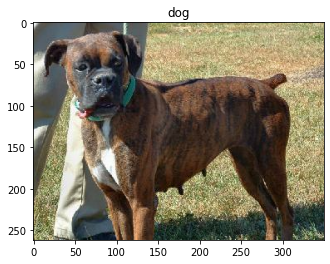

In [ ]:
get_label_name = metadata.features['label'].int2str  # creates a function object that we can use to get labels get_lame_name['cat','dog']

# display 2 images from the dataset
for image, label in raw_train.take(1):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [ ]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
  """
  returns an image that is reshaped to IMG_SIZE
  """
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [ ]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example) 

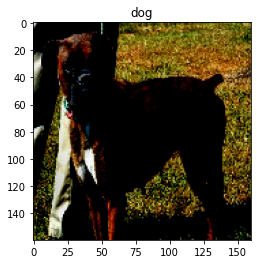

In [ ]:
for image, label in train.take(1):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [151]:
BATCH_SIZE = 100
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [ ]:
print(validation_batches)

<BatchDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int64)>


In [ ]:
for img, label in raw_train.take(2):
  print("Original shape:", img.shape)

for img, label in train.take(2):
  print("New shape:", img.shape)

Original shape: (262, 350, 3)
Original shape: (409, 336, 3)
New shape: (160, 160, 3)
New shape: (160, 160, 3)


In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
for image, _ in train_batches.take(1):
   pass
feature_batch = base_model(image)
print(feature_batch.shape)

(40, 5, 5, 1280)


In [ ]:
np.array(image).shape

(40, 160, 160, 3)

In [ ]:
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [ ]:
prediction_layer = keras.layers.Dense(1)

In [ ]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# We can evaluate the model right now to see how it does before training it on our new images
initial_epochs =1
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 15s 732ms/step - loss: 0.7291 - accuracy: 0.5688


In [ ]:
# Now we can train it on our images
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

acc = history.history['accuracy']
print(acc)

466/466 [==============================] - 410s 879ms/step - loss: 0.2304 - accuracy: 0.9032 - val_loss: 0.0982 - val_accuracy: 0.9635
[0.9031703472137451]


In [ ]:
model.save("dogs_vs_cats.h5")  # we can save the model and reload it at anytime in the future
new_model = tf.keras.models.load_model('dogs_vs_cats.h5')

In [158]:
image_batch, label_batch = test_batches.shuffle(100).as_numpy_iterator().next()

Pick a number: 12


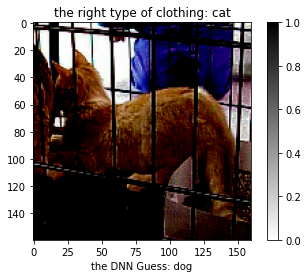

In [163]:
COLOR = 'black'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR

def predict(model, image, correct_label,num):
  class_names = ['cat','dog']
  prediction = model.predict_on_batch(image).flatten()
  prediction = tf.nn.sigmoid(prediction)
  prediction = tf.where(prediction < 0.5, 0, 1)
  prediction=prediction.numpy()
  a=correct_label[num]
  b=prediction[num]
  show_image(image[num], class_names[a],class_names[b])

def predict1(model, image, correct_label):
  
  prediction = model.predict_on_batch(image).flatten()
  prediction = tf.nn.sigmoid(prediction)
  prediction = tf.where(prediction < 0.5, 0, 1)
  prediction=prediction.numpy()
  

  return (image, prediction)


def show_image(img, label, guess):
  plt.figure()
  plt.imshow(img, cmap=plt.cm.binary)
  plt.title("the right type of clothing: " + label)
  plt.xlabel("the DNN Guess: " + guess)
  plt.colorbar()
  plt.grid(False)
  plt.show()


def get_number():
  while True:
    num = input("Pick a number: ")
    if num.isdigit():
      num = int(num)
      if 0 <= num <= 1000:
        return int(num)
    else:
      print("Try again...")


num = get_number()
image = image_batch
label = label_batch


predict(model,image,label,num)

In [160]:
def sample_images(img, label):
        class_names = ['cat','dog']
        r, c =3,5
        noise = np.random.normal(0, 1, (r * c, 100))
        pre=predict1(model,img,label)
        gen_imgs =pre[0]

        # Rescale images 0 - 1
        #gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                axs[i,j].set_title(class_names[pre[1][cnt]])
                cnt += 1

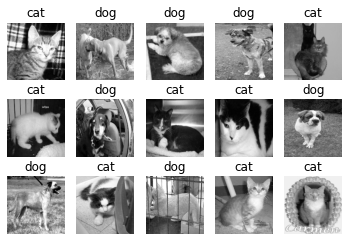

In [161]:
sample_images(image,label)